# Error in 3D

In this notebook we load the points OpenPTV creates errors in 3D from 
Robin generated 2D and 3D points, see also proPTV_LineOfSight/generate_error.py

and markers_c0.txt, ...


In [1]:
import pandas as pd
import numpy as np
from typing import List, Tuple

from openptv_python.calibration import Calibration
from openptv_python.parameters import ControlPar, VolumePar, MultimediaPar
from openptv_python.orientation import skew_midpoint
from openptv_python.ray_tracing import ray_tracing

import pathlib, os
working_path = pathlib.Path.cwd()

In [2]:
class Parameter:
    cams = [0,1,2,3]
    Vmin = [0,0,0]
    Vmax = [300,300,300]
    N1, N2 = 361, 5

In [3]:
params = Parameter()

markers = [np.loadtxt('../proPTV_LineOfSight/markers_c'+str(cam)+'.txt') for cam in params.cams]
XYZ = markers[0][:,2:]
xy = markers[0][:,:2]
ID = np.argwhere((XYZ[:,0]>-1))[:,0]

In [4]:
xyz = pd.DataFrame(XYZ, columns=['x','y','z'])
xyz['id'] = ID
# px.scatter_3d(x=xyz['x'], y=xyz['y'], z=xyz['z'], color=xyz['id']).show()

In [5]:

cal = [Calibration().from_file(working_path / "calibration" / f"cam{cam_id+1}.tif.ori", None) for cam_id in range(4)]
# cal = [Calibration().from_file(working_path / "calibration" / f"cam{cam_id+1}.ori", working_path / "calibration" / f"cam{cam_id+1}.addpar") for cam_id in range(4)]
cpar = ControlPar().from_file(working_path / "parameters" / "ptv.par")
vpar = VolumePar().from_file(working_path / "parameters" / "criteria.par")

No addpar file found. Using default values for radial distortion
No addpar file found. Using default values for radial distortion
No addpar file found. Using default values for radial distortion
No addpar file found. Using default values for radial distortion


In [6]:
def point_position(
    targets: np.ndarray, # markers
    num_cams: int,
    multimed_pars: MultimediaPar,
    cals: List[Calibration],
) -> Tuple[float, np.ndarray]:
    """
    Calculate an average 3D position implied by the rays.

    sent toward it from cameras through the image projections of the point.

    Arguments:
    ---------
    targets - for each camera, the 2D metric, flat, centred coordinates
        of the identified point projection.
    multimed_pars - multimedia parameters struct for ray tracing through
        several layers.
    cals - each camera's calibration object.

    Returns
    -------
    A tuple containing the ray convergence measure (an average of skew ray distance across all ray pairs)
    and the average 3D position vector.
    """
    # loop counters
    num_used_pairs = 0
    dtot = 0.0
    point_tot = np.array([0.0, 0.0, 0.0])

    vertices = np.zeros((num_cams, 3))
    directs = np.zeros((num_cams, 3))
    point = np.zeros(3)
    
        # Shoot rays from all cameras.
    for cam in range(num_cams):
        vertices[cam], directs[cam] = ray_tracing(
            targets[cam][0], targets[cam][1], cals[cam], multimed_pars
        )

    # Check intersection distance for each pair of rays and find position
    for cam in range(num_cams):
        # if targets[cam][0] == COORD_UNUSED:
        #     continue

        for pair in range(cam + 1, num_cams):
            # if targets[pair][0] == COORD_UNUSED:
            #     continue

            num_used_pairs += 1
            tmp, point = skew_midpoint(
                vertices[cam], directs[cam], vertices[pair], directs[pair]
            )
            dtot += tmp
            point_tot += point

    res = point_tot / num_used_pairs
    dtot /= num_used_pairs

    return float(dtot), res.astype(float)

In [7]:
tmp = [[markers[cam][row,:2] for cam in range(4)] for row in range(1805)]

In [8]:
from openptv_python.trafo import pixel_to_metric, dist_to_flat
def pixel_to_flat(pos, cpar, cal):
    """ converts numpy array of size (2,) from pixel to flat coordinates"""
    pos[0], pos[1] = pixel_to_metric( pos[0], pos[1], cpar)
    pos[0], pos[1] = dist_to_flat( pos[0], pos[1], cal, 1e-5 )
    return pos


In [9]:
# convert all the markers to flat coordinates
newtmp = [[pixel_to_flat(pos, cpar, cal[i]) for i, pos in enumerate(row)] for row in tmp]

In [10]:
newXYZ = []
for row in newtmp:
    eps, pos = point_position(row, 4, cpar.mm, cal)
    newXYZ.append(pos)
    
newXYZ = np.array(newXYZ)

In [11]:
XYZ, newXYZ

(array([[ 15.,  15., 274.],
        [ 30.,  15., 274.],
        [ 45.,  15., 274.],
        ...,
        [255., 285.,  26.],
        [270., 285.,  26.],
        [285., 285.,  26.]]),
 array([[ 14.06552182,  14.098963  , 274.25312275],
        [ 29.0386693 ,  14.03013227, 274.1657115 ],
        [ 44.14178322,  14.02100531, 274.52545013],
        ...,
        [253.73236725, 283.42745682,  25.71568899],
        [268.47770896, 283.42373486,  25.72583744],
        [283.33652145, 283.21341016,  26.38136187]]))

In [12]:
import plotly.express as px
px.scatter_3d(x=xyz['x'], y=xyz['y'], z=xyz['z'], color=xyz['id']).show()

In [13]:
newxyz = pd.DataFrame(newXYZ, columns=['x','y','z'])
newxyz['id'] = ID
px.scatter_3d(x=newxyz['x'], y=newxyz['y'], z=newxyz['z'], color=newxyz['id']).show()

In [14]:
px.scatter_3d(x=xyz['x']-newxyz['x'], y=xyz['y']-newxyz['y'], z=xyz['z']-newxyz['z'], color=xyz['id']).show()

In [15]:
df = xyz - newxyz

array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'id'}>]],
      dtype=object)

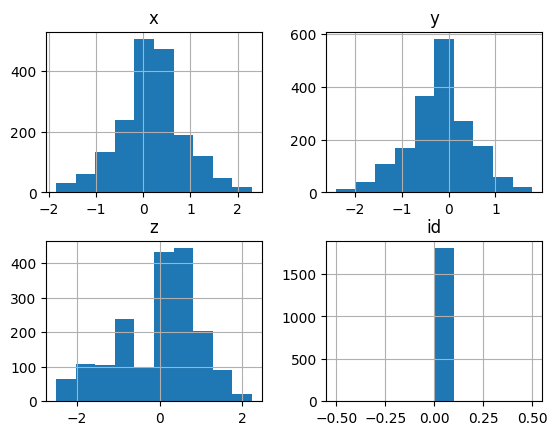

In [17]:
df.hist()

In [16]:
df.to_csv('difference_openptv.csv')